In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
%matplotlib inline

In [2]:
test = pd.read_csv("test_users.csv")
train = pd.read_csv("train_users_2.csv")
sessions = pd.read_csv("sessions.csv")

In [3]:
print('There were', train.shape[0], 'users in the training set and', test.shape[0], 'in the test set.')
print('In total there were', train.shape[0] + test.shape[0], 'users.')
print('There were', sessions.shape[0], 'recorded sessions to which there were', sessions.user_id.nunique(), 'unique users in the sessions data.')

There were 213451 users in the training set and 62096 in the test set.
In total there were 275547 users.
There were 10567737 recorded sessions to which there were 135483 unique users in the sessions data.


We have way more users in users data than sessions data.

## Sessions Data Exploring, Preprocessing & Feature Engineering

After playing around with the data sets for several times, I realized the best way is to start with sessions data.

In [4]:
sessions.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

### Missing values

There are so many missing values in sessions data, we have no choice but find a way to fill them.

First, we drop rows where user_id is null.

In [5]:
sessions = sessions[sessions.user_id.notnull()]

In [6]:
sessions.isnull().sum()

user_id                0
action             79480
action_type      1122957
action_detail    1122957
device_type            0
secs_elapsed      135483
dtype: int64

#### Missing values in action

In [7]:
sessions[sessions.action.isnull()].head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
45,d1mm9tcy42,NaN,message_post,message_post,Windows Desktop,NaN
138,4grx6yxeby,NaN,message_post,message_post,Windows Desktop,59801.0
317,xwxei6hdk4,NaN,message_post,message_post,iPad Tablet,NaN
320,xwxei6hdk4,NaN,message_post,message_post,iPad Tablet,0.0
382,ro2stddszp,NaN,message_post,message_post,Mac Desktop,7192.0


In [8]:
sessions[sessions.action.isnull()].action_type.value_counts()

message_post    79480
Name: action_type, dtype: int64

We find in all the nulls in action feature, have a "message_post" in action_type and action_detail features. So we will fill all the nulls in action feature with "message".

In [9]:
sessions.loc[sessions.action.isnull(), 'action'] = 'message'

In [10]:
sessions.isnull().sum()

user_id                0
action                 0
action_type      1122957
action_detail    1122957
device_type            0
secs_elapsed      135483
dtype: int64

#### Missing values in action_type and action_detail

The following are the missing values in action_type and action_detail features that we have to fill, and they all have the same rows that are missing.

In [11]:
print(sessions[sessions.action_type.isnull()].action.value_counts())
print('---')
print(sessions[sessions.action_detail.isnull()].action.value_counts())

show                      580485
similar_listings_v2       168457
lookup                    161422
campaigns                 104331
track_page_view            80949
index                      16682
localization_settings       5380
uptodate                    3329
signed_out_modal            1054
currencies                   292
update                       225
braintree_client_token       120
check                        119
widget                        75
phone_verification            16
satisfy                        9
track_activity                 6
disaster_action                6
Name: action, dtype: int64
---
show                      580485
similar_listings_v2       168457
lookup                    161422
campaigns                 104331
track_page_view            80949
index                      16682
localization_settings       5380
uptodate                    3329
signed_out_modal            1054
currencies                   292
update                       225
braintree_cl

The following function finds the most common value of a feature, specific to each action, then fill in action_type and action_detail.

In [13]:
def most_common_value_by_all_users(merge_df, feature):
    new_df = pd.DataFrame(merge_df.groupby('action')[feature].value_counts())
    new_df['index_tuple'] = new_df.index
    new_df['count'] = new_df[feature]
    new_columns = ['action', feature]
    for n, col in enumerate(new_columns):
        new_df[col] = new_df.index_tuple.apply(lambda index_tuple: index_tuple[n])
        
    new_df = new_df.reset_index(drop=True)
    new_df = new_df.drop(['index_tuple'], axis=1)
    
    new_df_max = pd.DataFrame(new_df.groupby('action', as_index=False)['count'].max())
    new_df_max = new_df_max.merge(new_df, on = ['action', 'count'])
    new_df_max = new_df_max.drop('count', axis=1)
    merge_df = merge_df.merge(new_df_max, left_on = 'action', right_on = 'action', how='left')
    
    return merge_df
sessions = most_common_value_by_all_users(sessions, 'action_type')
sessions = most_common_value_by_all_users(sessions, 'action_detail')
sessions.loc[sessions.action_type_x.isnull(), 'action_type_x'] = sessions.action_type_y
sessions.loc[sessions.action_detail_x.isnull(), 'action_detail_x'] = sessions.action_detail_y
sessions['action_type'] = sessions.action_type_x
sessions['action_detail'] = sessions.action_detail_x
sessions.drop(['action_type_x', 'action_detail_x', 'action_type_y', 'action_detail_y'], axis=1, inplace=True)

In [14]:
sessions.isnull().sum()

user_id               0
action                0
device_type           0
secs_elapsed     135483
action_type      415562
action_detail    415562
dtype: int64

After that, we still have a lot of many missing values, such as missing values in action_type and action_detail where action as "similar_listings_v2", "lookup" and "track_page_view" and so on.

In [15]:
sessions[sessions.action_type.isnull()].action.value_counts()

similar_listings_v2       168457
lookup                    161422
track_page_view            80949
uptodate                    3329
signed_out_modal            1054
braintree_client_token       120
check                        119
widget                        75
phone_verification            16
satisfy                        9
disaster_action                6
track_activity                 6
Name: action, dtype: int64

In [16]:
print(sessions[sessions.action == 'similar_listings'].action_type.value_counts())
print('---')
print(sessions[sessions.action == 'similar_listings'].action_detail.value_counts())

data    363423
Name: action_type, dtype: int64
---
similar_listings    363423
Name: action_detail, dtype: int64


We noticed that action "similar_listing" has action_type as "data" and action_detail as "similar_listings". Therefore, we use those to fill action "similar_listings_v2".

In [17]:
sessions.loc[sessions.action == 'similar_listings_v2', 'action_type'] = 'data'
sessions.loc[sessions.action == 'similar_listings_v2', 'action_detail'] = 'similar_listings'

The rest are easy, and lastly, we fill "missing" to the ones we can't find them a home.

In [18]:
sessions.loc[sessions.action == 'lookup', 'action_type'] = 'lookup'
sessions.loc[sessions.action == 'lookup', 'action_detail'] = 'lookup'
sessions.loc[sessions.action == 'track_page_view', 'action_type'] = 'track_page_view'
sessions.loc[sessions.action == 'track_page_view', 'action_detail'] = 'track_page_view'
sessions.action_type = sessions.action_type.fillna('missing')
sessions.action_detail = sessions.action_detail.fillna('missing')

In [19]:
sessions.isnull().sum()

user_id               0
action                0
device_type           0
secs_elapsed     135483
action_type           0
action_detail         0
dtype: int64

#### Missing values in secs_elapsed

Fill the missing secs_elapsed with the median secs_elapsed for each action.

In [20]:
sessions["secs_elapsed"] = sessions.groupby("action").transform(lambda x: x.fillna(x.median()))

In [21]:
sessions.isnull().sum()

user_id          0
action           0
device_type      0
secs_elapsed     0
action_type      0
action_detail    0
dtype: int64

All done!

In [22]:
sessions.head()

,user_id,action,device_type,secs_elapsed,action_type,action_detail
0,d1mm9tcy42,lookup,Windows Desktop,319.0,lookup,lookup
1,d1mm9tcy42,search_results,Windows Desktop,67753.0,click,view_search_results
2,d1mm9tcy42,lookup,Windows Desktop,301.0,lookup,lookup
3,d1mm9tcy42,search_results,Windows Desktop,22141.0,click,view_search_results
4,d1mm9tcy42,lookup,Windows Desktop,435.0,lookup,lookup


### Feature Engineering

Based on current sessions dataframe, we create a new dataframe that finds each user's count of actions, sum of secs_elapsed, the most common value for a specific feature, the number of unique values of a feature, the maximum and minimum secs_elapsed, for each user, and so on.

#### action_count

In [23]:
sessions_new = pd.DataFrame(sessions.user_id.value_counts(sort=False))
sessions_new['action_count'] = sessions_new.user_id
sessions_new['user_id'] = sessions_new.index
sessions_new = sessions_new.reset_index(drop=True)

In [32]:
sessions_new.head()

,user_id,action_count
0,hivc6c5h99,13
1,b46vpqz2pp,39
2,2zs5vmvcbq,19
3,17q3fns1ft,116
4,ivwsqo67rb,94


#### Most frequent value in each feature (action, action_type, action_detail, device_type)

The following function returns the most frequent value in each feature, for a given user.

In [24]:
def most_frequent_value(merge_df, feature):
    # Group by the users and find the value counts of the feature
    new_df = pd.DataFrame(sessions.groupby('user_id')[feature].value_counts())
    # The index is a tuple, and we need to seperate it, so let's create a new feature from it.
    new_df['index_tuple'] = new_df.index
    # The new columns are the features created from the tuple.
    new_columns = ['user_id',feature]
    for n,col in enumerate(new_columns):
        new_df[col] = new_df.index_tuple.apply(lambda index_tuple: index_tuple[n])
    
    # Drop the old index (the tuple index)
    new_df = new_df.reset_index(drop = True)
    # Drop the unneeded feature
    new_df = new_df.drop('index_tuple', axis = 1)
    # Select the first value for each user, its most common
    new_df = new_df.groupby('user_id').first()
    
    # Set user_id equal to the index, then reset the index
    new_df['user_id'] = new_df.index
    new_df = new_df.reset_index(drop = True)
    
    merge_df = merge_df.merge(new_df)
    
    return merge_df

sessions_feature = ['action', 'action_type', 'action_detail', 'device_type']

for feature in sessions_feature:
    sessions_new = most_frequent_value(sessions_new, feature)

In [25]:
sessions_new.head()

,user_id,action_count,action,action_type,action_detail,device_type
0,e8zzuy8rk1,152,show,click,p3,Windows Desktop
1,upvhlkz4cu,16,show,view,p3,Windows Desktop
2,22n9cobcpk,72,show,view,-unknown-,Mac Desktop
3,u0fkrhizzl,12,show,view,-unknown-,Android Phone
4,gir1sb7mtg,29,show,view,user_profile,iPhone


#### The number of unique values of a feature for each user.

The following function returns the number of unique values of a feature for each user.

In [26]:
def unique_features(feature, feature_name, merge_df):
    # Create a dataframe by grouping the users and the feature
    unique_feature = pd.DataFrame(sessions.groupby('user_id')[feature].unique())
    unique_feature['user_id'] = unique_feature.index
    unique_feature = unique_feature.reset_index(drop = True)
    # Create a new feature equal to the number of unique features for each user
    unique_feature[feature_name] = unique_feature[feature].map(lambda x: len(x))
    # Drop the needed feature
    unique_feature = unique_feature.drop(feature, axis = 1)
    merge_df = merge_df.merge(unique_feature, on = 'user_id')
    return merge_df
sessions_new = unique_features('action', 'unique_actions', sessions_new)
sessions_new = unique_features('action_type', 'unique_action_types', sessions_new)
sessions_new = unique_features('action_detail', 'unique_action_details', sessions_new)
sessions_new = unique_features('device_type', 'unique_device_types', sessions_new)

In [27]:
sessions_new.head()

,user_id,action_count,action,action_type,action_detail,device_type,unique_actions,unique_action_types,unique_action_details,unique_device_types
0,e8zzuy8rk1,152,show,click,p3,Windows Desktop,22,7,17,1
1,upvhlkz4cu,16,show,view,p3,Windows Desktop,8,4,7,1
2,22n9cobcpk,72,show,view,-unknown-,Mac Desktop,28,7,23,1
3,u0fkrhizzl,12,show,view,-unknown-,Android Phone,7,4,6,1
4,gir1sb7mtg,29,show,view,user_profile,iPhone,6,5,8,1


In [346]:
# Find the maximum and minimum secs_elapsed/duration for each user in sessions.
# max_durations = pd.DataFrame(sessions.groupby(['user_id'], as_index=False)['secs_elapsed'].max())
# sessions_summary = sessions_summary.merge(max_durations, on = 'user_id')
# sessions_summary['max_duration'] = sessions_summary.secs_elapsed
# sessions_summary.drop('secs_elapsed', axis=1, inplace=True)

# min_durations = pd.DataFrame(sessions.groupby(['user_id'], as_index=False)['secs_elapsed'].min())
# sessions_summary = sessions_summary.merge(min_durations, on = 'user_id')
# sessions_summary['min_duration'] = sessions_summary.secs_elapsed
# sessions_summary.drop('secs_elapsed', axis=1, inplace=True)

# Find the average duration for each user
# sessions_summary['avg_duration'] = sessions_summary.duration / sessions_summary.action_count

#### secs_elapsed

We will extract information from secs_elapsed feature for each user, such as sum, mean, min, max, median, if the sum of secs_elapsed is greater than 86,400 second, we consider day_pause, if the sum of secs_elapsed is greater than 300,000 seconds, we consider it is a long pause, and if the sum of secs_elapsed is shorter than 3,600 seconds, we consider it is a short pause.

In [28]:
secs_elapsed = sessions.groupby('user_id')['secs_elapsed']

secs_elapsed = secs_elapsed.agg(
    {
        'secs_elapsed_sum': np.sum,
        'secs_elapsed_mean': np.mean,
        'secs_elapsed_min': np.min,
        'secs_elapsed_max': np.max,
        'secs_elapsed_median': np.median,
        'day_pauses': lambda x: (x > 86400).sum(),
        'long_pauses': lambda x: (x > 300000).sum(),
        'short_pauses': lambda x: (x < 3600).sum(),
        'session_length' : np.count_nonzero
    }
)
secs_elapsed.reset_index(inplace=True)
sessions_new = pd.merge(sessions_new, secs_elapsed, on='user_id', how='left')

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  del sys.path[0]


In [29]:
sessions_new.head()

,user_id,action_count,action,action_type,action_detail,device_type,unique_actions,unique_action_types,unique_action_details,unique_device_types,secs_elapsed_sum,secs_elapsed_mean,secs_elapsed_min,secs_elapsed_max,secs_elapsed_median,day_pauses,long_pauses,short_pauses,session_length
0,e8zzuy8rk1,152,show,click,p3,Windows Desktop,22,7,17,1,6503214.5,42784.305921,0.0,1220337.0,743.0,18.0,5.0,99.0,142.0
1,upvhlkz4cu,16,show,view,p3,Windows Desktop,8,4,7,1,237087.5,14817.968750,124.0,116057.0,3245.5,1.0,0.0,10.0,16.0
2,22n9cobcpk,72,show,view,-unknown-,Mac Desktop,28,7,23,1,2441601.5,33911.131944,0.0,1209080.0,2021.5,4.0,2.0,39.0,71.0
3,u0fkrhizzl,12,show,view,-unknown-,Android Phone,7,4,6,1,25734.0,2144.500000,11.0,10474.0,751.0,0.0,0.0,9.0,12.0
4,gir1sb7mtg,29,show,view,user_profile,iPhone,6,5,8,1,266474.5,9188.775862,21.0,67506.0,566.0,0.0,0.0,16.0,29.0


In [30]:
sessions_new.isnull().sum()

user_id                  0
action_count             0
action                   0
action_type              0
action_detail            0
device_type              0
unique_actions           0
unique_action_types      0
unique_action_details    0
unique_device_types      0
secs_elapsed_sum         0
secs_elapsed_mean        0
secs_elapsed_min         0
secs_elapsed_max         0
secs_elapsed_median      0
day_pauses               0
long_pauses              0
short_pauses             0
session_length           0
dtype: int64

#### New features

Add new features to categorize the type of device that the user used most frequently.

In [31]:
apple_device = ['Mac Desktop','iPhone','iPdad Tablet','iPodtouch']
desktop_device = ['Mac Desktop','Windows Desktop','Chromebook','Linux Desktop']
tablet_device = ['Android App Unknown Phone/Tablet','iPad Tablet','Tablet']
mobile_device = ['Android Phone','iPhone','Windows Phone','Blackberry','Opera Phone']

device_types = {'apple_device': apple_device, 
                'desktop_device': desktop_device,
                'tablet_device': tablet_device,
                'mobile_device': mobile_device}
for device in device_types:
    sessions_new[device] = 0
    sessions_new.loc[sessions_new.device_type.isin(device_types[device]), device] = 1

In [32]:
sessions_new.head()

,user_id,action_count,action,action_type,action_detail,device_type,unique_actions,unique_action_types,unique_action_details,unique_device_types,...,secs_elapsed_max,secs_elapsed_median,day_pauses,long_pauses,short_pauses,session_length,apple_device,desktop_device,tablet_device,mobile_device
0,e8zzuy8rk1,152,show,click,p3,Windows Desktop,22,7,17,1,...,1220337.0,743.0,18.0,5.0,99.0,142.0,0,1,0,0
1,upvhlkz4cu,16,show,view,p3,Windows Desktop,8,4,7,1,...,116057.0,3245.5,1.0,0.0,10.0,16.0,0,1,0,0
2,22n9cobcpk,72,show,view,-unknown-,Mac Desktop,28,7,23,1,...,1209080.0,2021.5,4.0,2.0,39.0,71.0,1,1,0,0
3,u0fkrhizzl,12,show,view,-unknown-,Android Phone,7,4,6,1,...,10474.0,751.0,0.0,0.0,9.0,12.0,0,0,0,1
4,gir1sb7mtg,29,show,view,user_profile,iPhone,6,5,8,1,...,67506.0,566.0,0.0,0.0,16.0,29.0,1,0,0,1


In [33]:
print(sessions_new.shape)
print(train.shape)
print(test.shape)

(135483, 23)
(213451, 16)
(62096, 15)


## Users Data Exploring, Preprocessing & Feature Engineering

Merge train and test with newly created sessions data.

In [47]:
# train = train.merge(sessions_new, left_on = train['id'], right_on = sessions_new['user_id'], how='inner')
# test = test.merge(sessions_new, left_on = test['id'], right_on = sessions_new['user_id'], how = 'inner')
# df = pd.concat([train,test])

In [34]:
train1 = train.merge(sessions_new, left_on = train['id'], right_on = sessions_new['user_id'], how='inner')
train2 = train[~train.id.isin(train1.id)]
train = pd.concat([train1, train2])
test1 = test.merge(sessions_new, left_on = test['id'], right_on = sessions_new['user_id'], how = 'inner')
test2 = test[~test.id.isin(test1.id)]
test = pd.concat([test1, test2])
df = pd.concat([train,test])

In [35]:
df.head()

,action,action_count,action_detail,action_type,affiliate_channel,affiliate_provider,age,apple_device,country_destination,date_account_created,...,signup_app,signup_flow,signup_method,tablet_device,timestamp_first_active,unique_action_details,unique_action_types,unique_actions,unique_device_types,user_id
0,show,127.0,p3,view,sem-non-brand,google,62.0,0.0,other,2014-01-01,...,Web,0,basic,0.0,20140101000936,10.0,7.0,17.0,2.0,d1mm9tcy42
1,show,9.0,p3,view,direct,direct,NaN,1.0,NDF,2014-01-01,...,Web,0,basic,0.0,20140101001558,8.0,4.0,7.0,1.0,yo8nz8bqcq
2,create,16.0,-unknown-,-unknown-,sem-brand,google,NaN,0.0,NDF,2014-01-01,...,Web,0,basic,0.0,20140101001639,8.0,6.0,13.0,2.0,4grx6yxeby
3,ajax_refresh_subtotal,152.0,change_trip_characteristics,click,direct,direct,NaN,0.0,NDF,2014-01-01,...,Web,0,basic,0.0,20140101002146,13.0,7.0,19.0,3.0,ncf87guaf0
4,index,8.0,-unknown-,-unknown-,direct,direct,NaN,1.0,GB,2014-01-01,...,iOS,25,basic,0.0,20140101002619,1.0,1.0,7.0,1.0,4rvqpxoh3h


In [36]:
df.isnull().sum()

action                     140064
action_count               140064
action_detail              140064
action_type                140064
affiliate_channel               0
affiliate_provider              0
age                        116866
apple_device               140064
country_destination         62096
date_account_created            0
date_first_booking         186639
day_pauses                 140064
desktop_device             140064
device_type                140064
first_affiliate_tracked      6085
first_browser                   0
first_device_type               0
gender                          0
id                              0
language                        0
long_pauses                140064
mobile_device              140064
secs_elapsed_max           140064
secs_elapsed_mean          140064
secs_elapsed_median        140064
secs_elapsed_min           140064
secs_elapsed_sum           140064
session_length             140064
short_pauses               140064
signup_app    

In [37]:
df.drop(['user_id', 'date_first_booking'], axis=1, inplace=True)

### Missing values

Because there are many users in users data that do not appear in the sessions dataframe, therefore, all of their session values are null. Let's sort out those nulls values first. We will fill categorical nulls with "missing" and fill continuous nulls with 0.

In [41]:
def missing_session_data_cat(feature):
    return df[feature].fillna("missing")

def missing_session_data_cont(feature):
    return df[feature].fillna(0)

session_features_cat = ['action','action_detail','action_type','device_type']
session_features_cont = ['action_count','apple_device','desktop_device','mobile_device','tablet_device',
                         'secs_elapsed_max','secs_elapsed_mean','secs_elapsed_median','secs_elapsed_min', 'secs_elapsed_sum', 
                         'session_length', 'short_pauses', 'long_pauses', 'day_pauses', 'unique_action_details', 'unique_action_types', 
                         'unique_actions','unique_device_types']

for feature in session_features_cat:
    df[feature] = missing_session_data_cat(feature)
    
for feature in session_features_cont:
    df[feature] = missing_session_data_cont(feature)

By doing so, we are able to eliminate most of the nulls.

In [42]:
df.isnull().sum()

action                          0
action_count                    0
action_detail                   0
action_type                     0
affiliate_channel               0
affiliate_provider              0
age                        116866
apple_device                    0
country_destination         62096
date_account_created            0
day_pauses                      0
desktop_device                  0
device_type                     0
first_affiliate_tracked      6085
first_browser                   0
first_device_type               0
gender                          0
id                              0
language                        0
long_pauses                     0
mobile_device                   0
secs_elapsed_max                0
secs_elapsed_mean               0
secs_elapsed_median             0
secs_elapsed_min                0
secs_elapsed_sum                0
session_length                  0
short_pauses                    0
signup_app                      0
signup_flow   

By doing so, we are able to eliminate most of the nulls.

In [364]:
# Group action_count into quartiles.
# df['action_count_quartile'] = df.action_count.map(lambda x: 0 if x == 0 else (
#                                                            1 if x <= 17 else (
#                                                            2 if x <= 43 else (
#                                                            3 if x <= 97 else 4))))

### Users age feature

In [43]:
df[df.age.notnull()].age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

The maximum age is 2014, this is not possible. It seems that some users have filled a year instead of their age. Also the minimun age at 1 sounds rediculous. According to Airbnb's contract, users at the platform must be at least 18 years old. However, this is not enforced.

In [44]:
df.loc[df['age'] > 1000]['age'].describe()

count     828.000000
mean     2007.117150
std        22.219408
min      1920.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

In [45]:
df.loc[df['age'] < 18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

So we first correct mistakenly filled the age.

In [46]:
df_with_year = df['age'] > 1000
df.loc[df_with_year, 'age'] = 2015 - df.loc[df_with_year, 'age']

In [47]:
df.age.describe()

count    158681.000000
mean         36.713274
std          14.046364
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max         150.000000
Name: age, dtype: float64

After that, the Maximum age at 150 were not realistic, we will set max limit at 90, and bring down to 90 for anyone who is over 90 years old.

In [48]:
df.loc[df.age > 90, 'age'] = 90

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


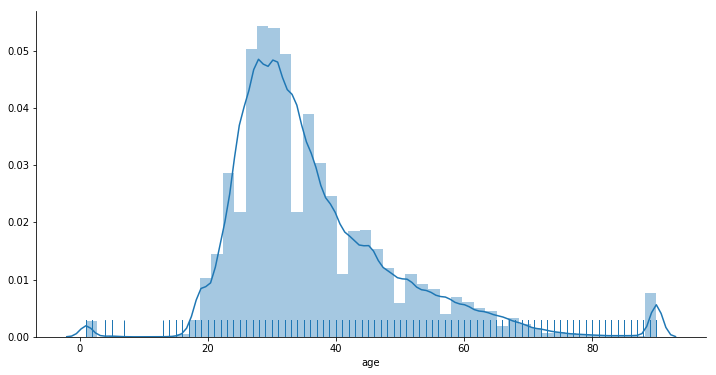

In [49]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.distplot(df.age.dropna(), rug=True)
sns.despine()

As expected, the most common age of Airbnb users is between 25 and 40. There are still too many nulls in age column. We are going to set the missing values equal to the median at 33. Before doing that, we create a new column for age_group.

In [50]:
df['age_group'] = df.age.map(lambda x: 0 if math.isnan(x) else (
                                       1 if x < 18 else (
                                       2 if x <= 32 else (
                                       3 if x <= 42 else 4))))

In [51]:
df.age = df.age.fillna(33)

### Users gender

In [52]:
df.gender.value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

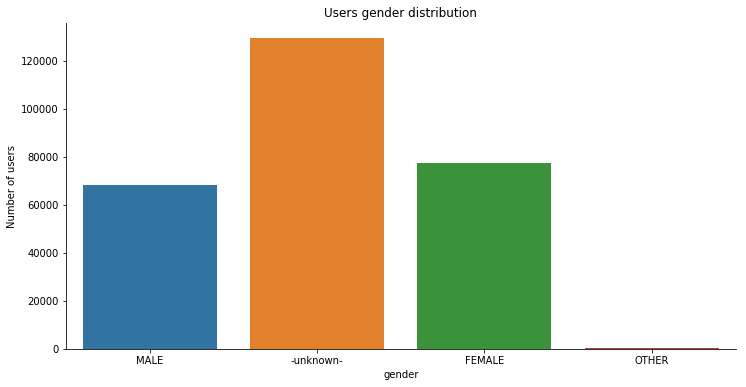

In [54]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='gender')
plt.ylabel('Number of users')
plt.title('Users gender distribution')
sns.despine()

Approx. 45% of users' gender were not presented. And there is no significant difference between female and male users on Airbnb's platform.

### Travel Destination Country

This is what we will predict in the test data.

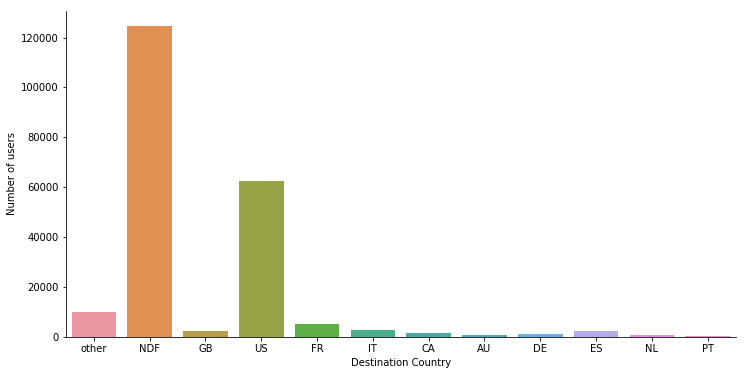

In [58]:
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data=df)
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
sns.despine()

Nearly 60% of users did not book any destination (NDF). The most booked country is the US (nearly 30% of all users booked US), given all users in the data set are from the US. We can say that US travelers in the dataset are more likely to travel within the US.

### signup_method

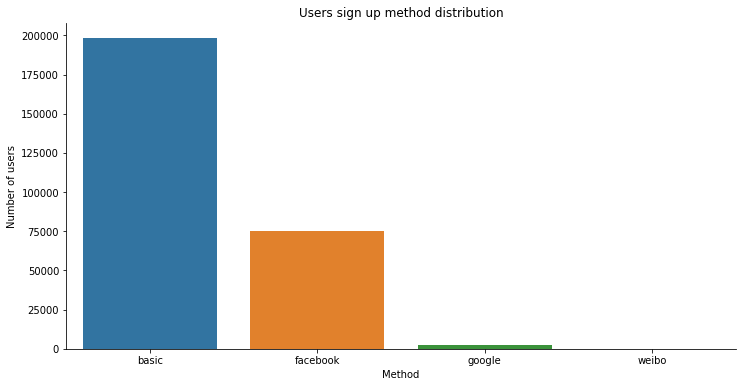

In [61]:
plt.figure(figsize=(12,6))
# df_without_NDF = df[df['country_destination']!='NDF']
sns.countplot(x='signup_method', data = df)
plt.xlabel('Method')
plt.ylabel('Number of users')
plt.title('Users sign up method distribution')
sns.despine()

Over 70% of all users in the data used basic email method to sign up with Airbnb, and less than 30% of bookers used their facebook account to sign up, approx. only 0.26% of the bookers in the data used their Google accounts to sign up.

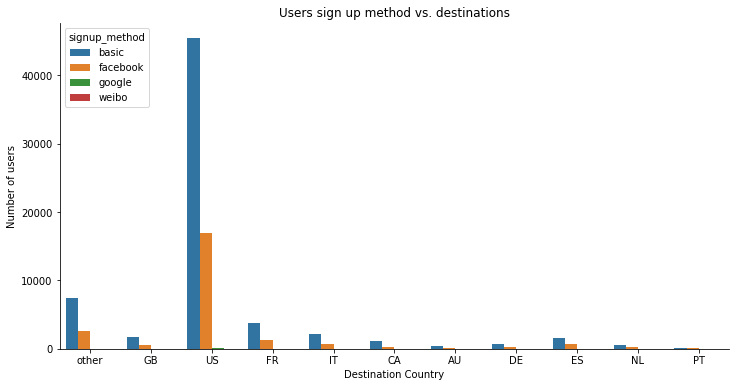

In [62]:
plt.figure(figsize=(12,6))
df_without_NDF = df[df['country_destination']!='NDF']
sns.countplot(x='country_destination', data = df_without_NDF, hue = 'signup_method')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('Users sign up method vs. destinations')
sns.despine()

For users who made booking at least once, most of them signed up with Airbnb through basic email method, no matter which country they were travelling to.

### signup_app

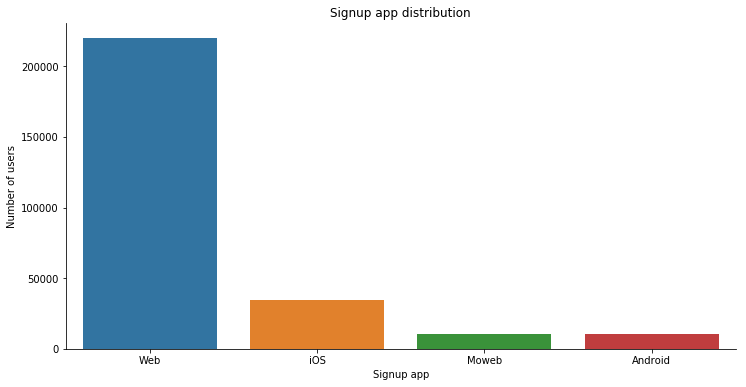

In [63]:
plt.figure(figsize=(12,6))
sns.countplot(x='signup_app', data=df)
plt.xlabel('Signup app')
plt.ylabel('Number of users')
plt.title('Signup app distribution')
sns.despine()

Over 85% of all bookers in the data set signed up on Airbnb's website, over 10% of all bookers signed up with iOs.

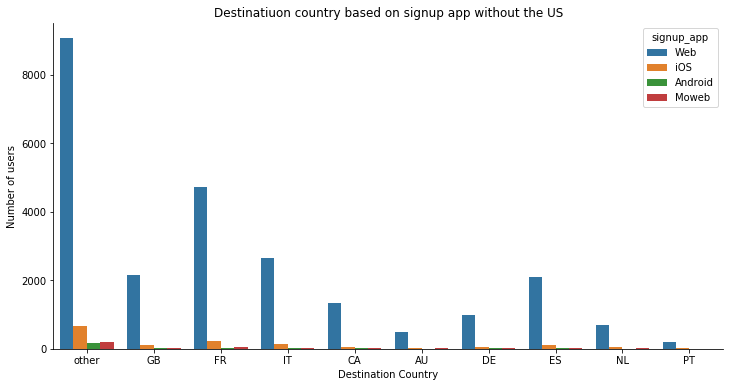

In [64]:
df_without_NDF_US = df_without_NDF[df_without_NDF['country_destination']!='US']
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data=df_without_NDF_US, hue='signup_app')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('Destinatiuon country based on signup app without the US')
sns.despine()

Signing up through Airbnb website is the most common sign up on users no matter which destination country they travel to in the data.

### first_device_type

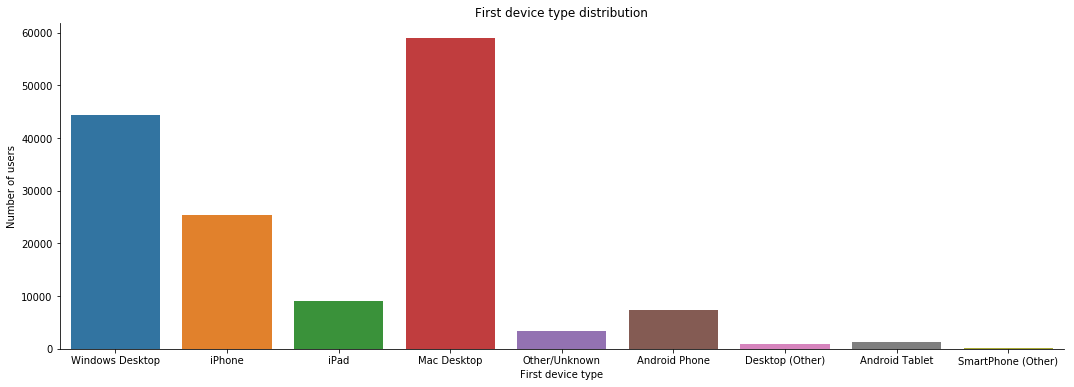

In [66]:
plt.figure(figsize=(18,6))
sns.countplot(x='first_device_type', data=df_without_NDF)
plt.xlabel('First device type')
plt.ylabel('Number of users')
plt.title('First device type distribution')
sns.despine()

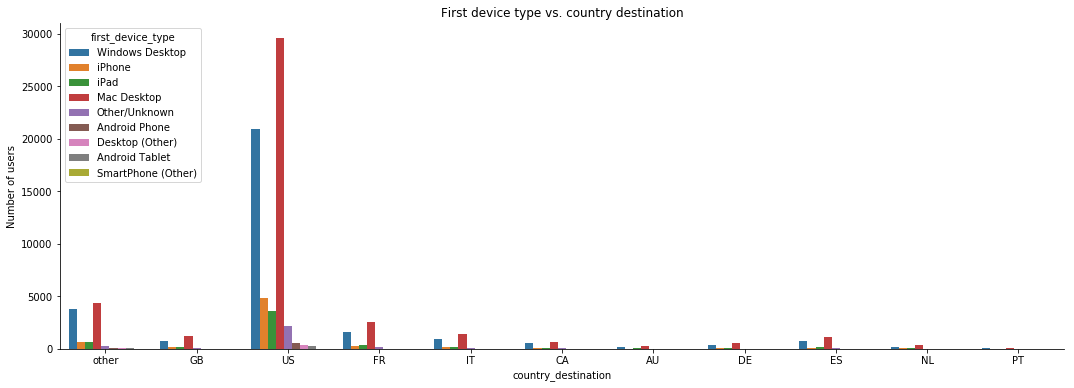

In [67]:
plt.figure(figsize=(18,6))
sns.countplot(x='country_destination', data=df_without_NDF, hue='first_device_type')
plt.ylabel('Number of users')
plt.title('First device type vs. country destination')
sns.despine()

Around 60% of bookers use Apple devices. Particularly in the US.

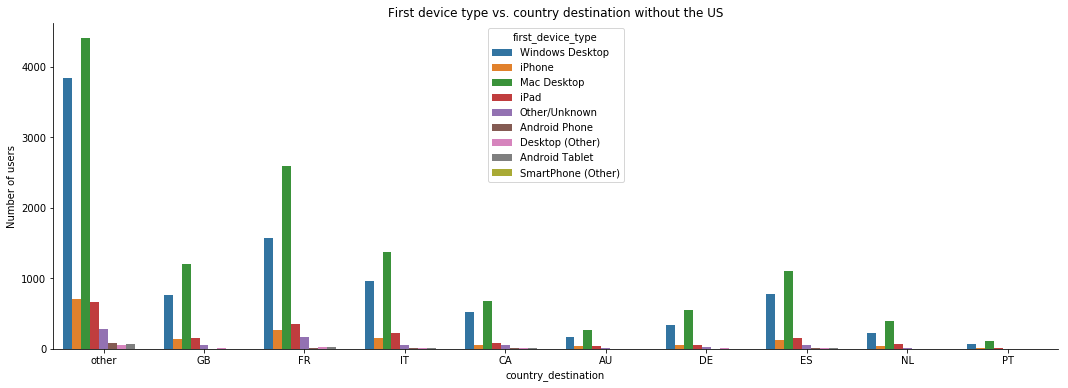

In [68]:
plt.figure(figsize=(18,6))
sns.countplot(x='country_destination', data=df_without_NDF_US, hue='first_device_type')
plt.ylabel('Number of users')
plt.title('First device type vs. country destination without the US')
sns.despine()

However, outside of the US, Windows descktop is far more common, in particular, there was little usage difference between Mac desktop and Windows desktop in Canada and Australia.

### Users preferred language

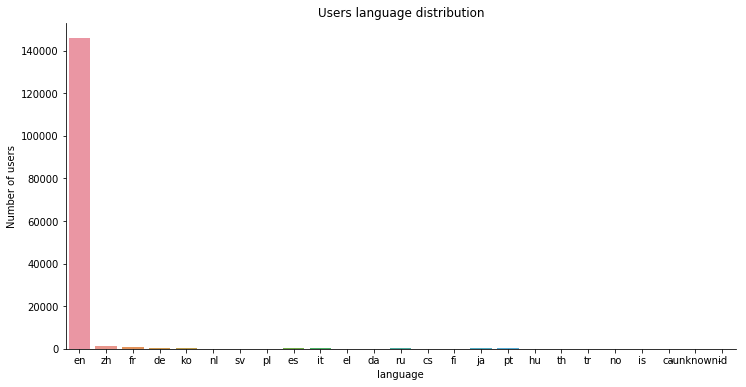

In [69]:
plt.figure(figsize=(12,6))
sns.countplot(x='language', data=df_without_NDF)
plt.xlabel('language')
plt.ylabel('Number of users')
plt.title('Users language distribution')
sns.despine()

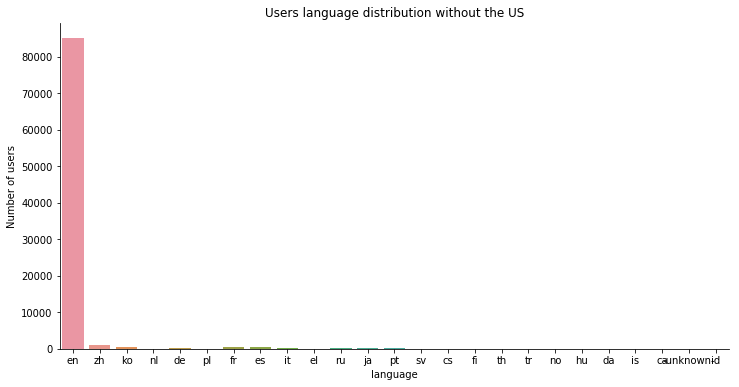

In [70]:
plt.figure(figsize=(12,6))
sns.countplot(x='language', data=df_without_NDF_US)
plt.xlabel('language')
plt.ylabel('Number of users')
plt.title('Users language distribution without the US')
sns.despine()

Even without the US, English is still the most preferred langauge, interestingly, Chinese is the 2nd most preferred languages for bookers.

### Date time features

Cast date columns to the correct data type and check to see they make sense.

In [71]:
df['date_account_created'] = pd.to_datetime(df['date_account_created'])
df['timestamp_first_active'] = pd.to_datetime((df.timestamp_first_active // 1000000), format='%Y%m%d')

print(df.timestamp_first_active.min())
print(df.timestamp_first_active.max())
print('---')
print(df.date_account_created.min())
print(df.date_account_created.max())

2009-03-19 00:00:00
2014-09-30 00:00:00
---
2010-01-01 00:00:00
2014-09-30 00:00:00


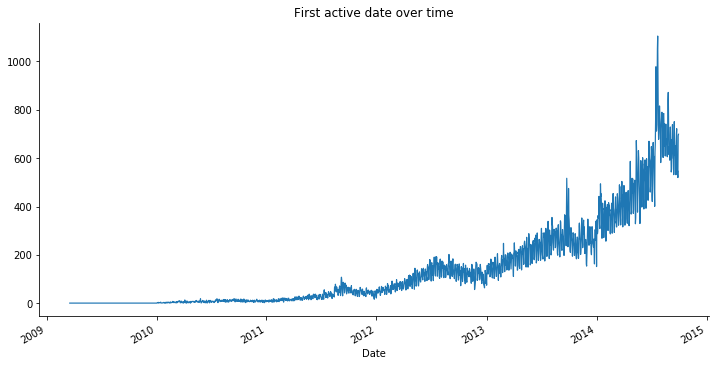

In [72]:
plt.figure(figsize=(12,6))
df.timestamp_first_active.value_counts().plot(kind='line', linewidth=1.2)
plt.xlabel('Date')
plt.title('First active date over time')
sns.despine()

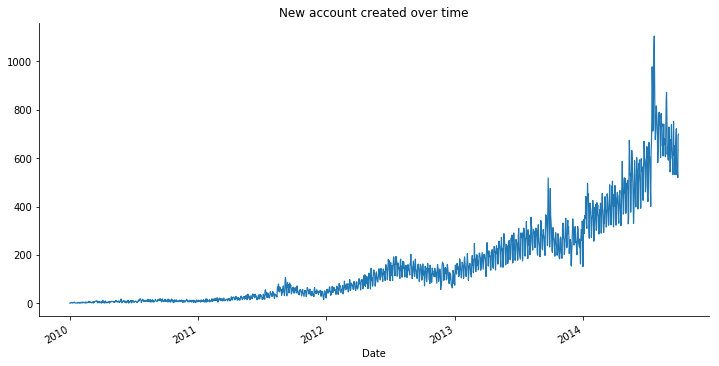

In [73]:
plt.figure(figsize=(12,6))
df.date_account_created.value_counts().plot(kind='line', linewidth=1.2)
plt.xlabel('Date')
plt.title('New account created over time')
sns.despine()

The pattern looks very similar between date account created and date first active, as it shoule be. From these two plots, we can see how fast Airbnb has grown since 2014.

### US Holidays

In [74]:
calendar = USFederalHolidayCalendar()
# Set holidays equal to the holidays in our date range.
holidays = calendar.holidays(start = df.timestamp_first_active.min(), 
                             end = df.timestamp_first_active.max())

# us_bd contains more years of information than we need.
us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())
# Set business_days equal to the work days in our date range.
business_days = pd.DatetimeIndex(start = df.timestamp_first_active.min(), 
                                 end = df.timestamp_first_active.max(), 
                                 freq = us_bd)

Create new date time features such as year, month, day of week, is business day, and is holiday.

In [75]:
df['year_account_created'] = df.date_account_created.dt.year
df['month_account_created'] = df.date_account_created.dt.month
df['weekday_account_created'] = df.date_account_created.dt.weekday
df['business_day_account_created'] = df.date_account_created.isin(business_days)
df['business_day_account_created'] = df.business_day_account_created.map(lambda x: 1 if x == True else 0)
df['holiday_account_created'] = df.date_account_created.isin(holidays)
df['holiday_account_created'] = df.holiday_account_created.map(lambda x: 1 if x == True else 0)

df['year_first_active'] = df.timestamp_first_active.dt.year
df['month_first_active'] = df.timestamp_first_active.dt.month
df['weekday_first_active'] = df.timestamp_first_active.dt.weekday
df['business_day_first_active'] = df.timestamp_first_active.isin(business_days)
df['business_day_first_active'] = df.business_day_first_active.map(lambda x: 1 if x == True else 0)
df['holiday_first_active'] = df.timestamp_first_active.isin(holidays)
df['holiday_first_active'] = df.holiday_first_active.map(lambda x: 1 if x == True else 0)

# Drop unneeded features
df = df.drop(["timestamp_first_active","date_account_created"], axis = 1)

In [76]:
df.head()

,action,action_count,action_detail,action_type,affiliate_channel,affiliate_provider,age,apple_device,country_destination,day_pauses,...,year_account_created,month_account_created,weekday_account_created,business_day_account_created,holiday_account_created,year_first_active,month_first_active,weekday_first_active,business_day_first_active,holiday_first_active
0,show,127.0,p3,view,sem-non-brand,google,62.0,0.0,other,11.0,...,2014,1,2,0,1,2014,1,2,0,1
1,show,9.0,p3,view,direct,direct,33.0,1.0,NDF,1.0,...,2014,1,2,0,1,2014,1,2,0,1
2,create,16.0,-unknown-,-unknown-,sem-brand,google,33.0,0.0,NDF,4.0,...,2014,1,2,0,1,2014,1,2,0,1
3,ajax_refresh_subtotal,152.0,change_trip_characteristics,click,direct,direct,33.0,0.0,NDF,11.0,...,2014,1,2,0,1,2014,1,2,0,1
4,index,8.0,-unknown-,-unknown-,direct,direct,33.0,1.0,GB,0.0,...,2014,1,2,0,1,2014,1,2,0,1


In [388]:
# Set nulls values equal to one less than the minimum.
# I could set the nulls to 0, but the scale would be ugly when we normalize the features.
# df.year_first_booking = df.year_first_booking.fillna(min(df.year_first_booking) - 1)
# df.month_first_booking = df.month_first_booking.fillna(min(df.month_first_booking) - 1)
# df.weekday_first_booking += 1
# df.weekday_first_booking = df.weekday_first_booking.fillna(0)

In [77]:
df.isnull().sum()

action                              0
action_count                        0
action_detail                       0
action_type                         0
affiliate_channel                   0
affiliate_provider                  0
age                                 0
apple_device                        0
country_destination             62096
day_pauses                          0
desktop_device                      0
device_type                         0
first_affiliate_tracked          6085
first_browser                       0
first_device_type                   0
gender                              0
id                                  0
language                            0
long_pauses                         0
mobile_device                       0
secs_elapsed_max                    0
secs_elapsed_mean                   0
secs_elapsed_median                 0
secs_elapsed_min                    0
secs_elapsed_sum                    0
session_length                      0
short_pauses

### first_affiliate_tracked

In [78]:
df['first_affiliate_tracked'].value_counts()

untracked        143181
linked            62064
omg               54859
tracked-other      6655
product            2353
marketing           281
local ops            69
Name: first_affiliate_tracked, dtype: int64

Set the missing values for "first_affiliate_tracked" to "untracked".

In [79]:
df.first_affiliate_tracked = df.first_affiliate_tracked.fillna("untracked")

In [80]:
df.isnull().sum()

action                              0
action_count                        0
action_detail                       0
action_type                         0
affiliate_channel                   0
affiliate_provider                  0
age                                 0
apple_device                        0
country_destination             62096
day_pauses                          0
desktop_device                      0
device_type                         0
first_affiliate_tracked             0
first_browser                       0
first_device_type                   0
gender                              0
id                                  0
language                            0
long_pauses                         0
mobile_device                       0
secs_elapsed_max                    0
secs_elapsed_mean                   0
secs_elapsed_median                 0
secs_elapsed_min                    0
secs_elapsed_sum                    0
session_length                      0
short_pauses

The null values in 'country_destination' belong to the testing data. Now let's explore the categorical features that might have too many values and reduce that number before we do one-hot encoding.

#### first_browser_value_count

In [81]:
df.first_browser.value_counts()

Chrome                  78671
Safari                  53302
-unknown-               44394
Firefox                 38665
Mobile Safari           29636
IE                      24744
Chrome Mobile            3186
Android Browser          1577
AOL Explorer              254
Opera                     228
Silk                      172
IE Mobile                 118
BlackBerry Browser         89
Chromium                   83
Mobile Firefox             64
Maxthon                    60
Apple Mail                 45
Sogou Explorer             43
SiteKiosk                  27
RockMelt                   24
Iron                       24
IceWeasel                  14
Yandex.Browser             14
Pale Moon                  13
CometBird                  12
SeaMonkey                  12
Camino                      9
TenFourFox                  8
Opera Mini                  8
wOSBrowser                  7
CoolNovo                    6
Opera Mobile                4
Avant Browser               4
Mozilla   

In [82]:
# Create a new feature for those using mobile browsers
mobile_browsers = ['Mobile Safari','Chrome Mobile','IE Mobile','Mobile Firefox','Android Browser']
df.loc[df.first_browser.isin(mobile_browsers), "first_browser"] = "Mobile"
# The cut_off is set at 2000. If a value is less than 2000, it will be grouped "other"
cut_off = 2000

other_browsers = []
for browser, count in df.first_browser.value_counts().iteritems():
    if count < cut_off:
        other_browsers.append(browser)
df.loc[df.first_browser.isin(other_browsers), "first_browser"] = "Other"
df.first_browser.value_counts()

Chrome       78671
Safari       53302
-unknown-    44394
Firefox      38665
Mobile       34581
IE           24744
Other         1190
Name: first_browser, dtype: int64

#### language

In [83]:
df.language.value_counts()

en           265538
zh             2634
fr             1508
es             1174
ko             1116
de              977
it              633
ru              508
ja              345
pt              322
sv              176
nl              134
tr               92
da               75
pl               75
no               51
cs               49
el               30
th               28
hu               25
id               23
fi               20
ca                6
is                5
hr                2
-unknown-         1
Name: language, dtype: int64

In [84]:
# I think that language might be a more important feature than some others, so I will decrease the cut off to 275, or 0.1% of the data.
other_languages = []
for language, count in df.language.value_counts().iteritems():
    if count < 200:
        other_languages.append(language)
df.loc[df.language.isin(other_languages), "language"] = "Other"   
df.language.value_counts()

en       265538
zh         2634
fr         1508
es         1174
ko         1116
de          977
Other       792
it          633
ru          508
ja          345
pt          322
Name: language, dtype: int64

In [85]:
# New feature for languages that are not English.
df['not_English'] = df.language.map(lambda x: 0 if x == 'en' else 1)

#### action

In [86]:
df.action.value_counts()

missing                                         140064
show                                             61611
search_results                                   10368
index                                             6493
dashboard                                         5969
search                                            5895
active                                            5836
update                                            5264
create                                            4259
requested                                         3574
edit                                              2714
authenticate                                      2277
personalize                                       2256
header_userpic                                    1981
ajax_refresh_subtotal                             1851
ask_question                                      1756
identity                                          1269
lookup                                            1236
cancellati

In [87]:
other_actions = []
for action, count in df.action.value_counts().iteritems():
    if count < cut_off:
        other_actions.append(action)
df.loc[df.action.isin(other_actions), "action"] = "Other"
df.action.value_counts()

missing           140064
show               61611
Other              18967
search_results     10368
index               6493
dashboard           5969
search              5895
active              5836
update              5264
create              4259
requested           3574
edit                2714
authenticate        2277
personalize         2256
Name: action, dtype: int64

#### action_detail

In [88]:
df.action_detail.value_counts()

missing                        140069
-unknown-                       35037
p3                              29387
view_search_results             28491
user_profile                    10037
dashboard                        4893
update_listing                   4463
header_userpic                   2556
p5                               2489
create_user                      1991
message_thread                   1633
change_trip_characteristics      1598
contact_host                     1399
edit_profile                     1231
wishlist_content_update          1031
confirm_email_link                973
message_post                      774
cancellation_policies             742
track_page_view                   627
login                             559
signup                            496
lookup                            445
similar_listings                  401
listing_reviews                   326
unavailable_dates                 299
change_contact_host_dates         262
book_it     

In [89]:
other_action_details = []
for action_detail, count in df.action_detail.value_counts().iteritems():
    if count < cut_off:
        other_action_details.append(action_detail)
df.loc[df.action_detail.isin(other_action_details), "action_detail"] = "Other"
df.action_detail.value_counts()

missing                140069
-unknown-               35037
p3                      29387
view_search_results     28491
Other                   18125
user_profile            10037
dashboard                4893
update_listing           4463
header_userpic           2556
p5                       2489
Name: action_detail, dtype: int64

#### action_type

In [90]:
df.action_type.value_counts()

missing             140070
view                 76491
click                18345
-unknown-            17724
data                 14750
submit                6485
message_post           998
track_page_view        316
partner_callback       134
booking_request        123
lookup                 109
modify                   2
Name: action_type, dtype: int64

In [91]:
other_action_types = []
for action_type, count in df.action_type.value_counts().iteritems():
    if count < cut_off:
        other_action_types.append(action_type)
df.loc[df.action_type.isin(other_action_types), "action_type"] = "Other"
df.action_type.value_counts()

missing      140070
view          76491
click         18345
-unknown-     17724
data          14750
submit         6485
Other          1682
Name: action_type, dtype: int64

#### affiliate_provider

In [92]:
df.affiliate_provider.value_counts()

direct                 181270
google                  65956
other                   13036
facebook                 3996
bing                     3719
craigslist               3475
padmapper                 836
vast                      830
yahoo                     653
facebook-open-graph       566
gsp                       455
meetup                    358
email-marketing           270
naver                      66
baidu                      32
yandex                     18
wayn                        8
daum                        3
Name: affiliate_provider, dtype: int64

In [93]:
other_affiliate_providers = []
for affiliate_provider, count in df.affiliate_provider.value_counts().iteritems():
    if count < cut_off:
        other_affiliate_providers.append(affiliate_provider)
df.loc[df.affiliate_provider.isin(other_affiliate_providers), "affiliate_provider"] = "other"
df.affiliate_provider.value_counts()

direct        181270
google         65956
other          17131
facebook        3996
bing            3719
craigslist      3475
Name: affiliate_provider, dtype: int64

#### device_type

In [94]:
df.device_type.value_counts()

missing                             140064
Mac Desktop                          44279
Windows Desktop                      37224
iPhone                               26567
iPad Tablet                           8880
Android Phone                         7670
-unknown-                             5792
Android App Unknown Phone/Tablet      2629
Tablet                                1469
Linux Desktop                          428
Chromebook                             374
iPodtouch                               86
Windows Phone                           56
Blackberry                              27
Opera Phone                              2
Name: device_type, dtype: int64

In [95]:
other_device_types = []
for device_type, count in df.device_type.value_counts().iteritems():
    if count < cut_off:
        other_device_types.append(device_type)
df.loc[df.device_type.isin(other_device_types), "device_type"] = "Other"
df.device_type.value_counts()

missing                             140064
Mac Desktop                          44279
Windows Desktop                      37224
iPhone                               26567
iPad Tablet                           8880
Android Phone                         7670
-unknown-                             5792
Android App Unknown Phone/Tablet      2629
Other                                 2442
Name: device_type, dtype: int64

In [96]:
df.signup_method.value_counts()

basic       198222
facebook     74864
google        2438
weibo           23
Name: signup_method, dtype: int64

In [97]:
labels = pd.DataFrame(df.country_destination)
df = df.drop("country_destination", axis = 1)

In [98]:
labels.head()

,country_destination
0,other
1,NDF
2,NDF
3,NDF
4,GB


In [99]:
df.drop('id', axis=1, inplace=True)

In [100]:
# Group all features as either continuous (cont) or categorical (cat)
cont_features = []
cat_features = []

for feature in df.columns:
    if df[feature].dtype == float or df[feature].dtype == int:
        cont_features.append(feature)
    elif df[feature].dtype == object:
        cat_features.append(feature)

# Check to ensure that we have all of the features
print(cat_features)
print('---')
print(cont_features)
print('---')
print(len(cat_features) + len(cont_features))
print(df.shape[1])

['action', 'action_detail', 'action_type', 'affiliate_channel', 'affiliate_provider', 'device_type', 'first_affiliate_tracked', 'first_browser', 'first_device_type', 'gender', 'language', 'signup_app', 'signup_method']
---
['action_count', 'age', 'apple_device', 'day_pauses', 'desktop_device', 'long_pauses', 'mobile_device', 'secs_elapsed_max', 'secs_elapsed_mean', 'secs_elapsed_median', 'secs_elapsed_min', 'secs_elapsed_sum', 'session_length', 'short_pauses', 'tablet_device', 'unique_action_details', 'unique_action_types', 'unique_actions', 'unique_device_types']
---
32
45


Create dummy variables for each categorical feature

In [101]:
for feature in cat_features:
    # Create dummies of each value of a categorical feature
    dummies = pd.get_dummies(df[feature], prefix = feature, drop_first = False)
    # Drop the unneeded feature
    df = df.drop(feature, axis = 1)
    df = pd.concat([df, dummies], axis=1)
    print("{} is complete".format(feature))

action is complete
action_detail is complete
action_type is complete
affiliate_channel is complete
affiliate_provider is complete
device_type is complete
first_affiliate_tracked is complete
first_browser is complete
first_device_type is complete
gender is complete
language is complete
signup_app is complete
signup_method is complete


Preprocessing continuous variables

In [102]:
min_max_scaler = preprocessing.MinMaxScaler()
# Normalize the continuous features
for feature in cont_features:
    df.loc[:,feature] = min_max_scaler.fit_transform(df[[feature]])

In [103]:
# Split df into training and testing data
df_train = df[:len(train)]
df_test = df[len(train):]

# Shorten labels to length of the training data
y = labels[:len(train)]

In [104]:
df_train.shape

(213451, 132)

In [105]:
y.shape

(213451, 1)

In [106]:
x_train, x_test, y_train, y_test = train_test_split(df_train, y, test_size = 0.33, random_state = 2)

In [107]:
from sklearn.preprocessing import LabelEncoder

x_train = x_train.values

label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [108]:
import xgboost as xgb

xgtrain = xgb.DMatrix(x_train, label=encoded_y_train)

In [109]:
def ndcg_score(preds, dtrain):
    labels = dtrain.get_label()
    top = []

    for i in range(preds.shape[0]):
        top.append(np.argsort(preds[i])[::-1][:5])

    mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int)
    score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1))
    return 'ndcg', score

In [110]:
param = {
    'max_depth': 10,
    'learning_rate': 1,
    'n_estimators': 5,
    'objective': 'multi:softprob',
    'num_class': 12,
    'gamma': 0,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'base_score': 0.5,
    'missing': None,
    'silent': True,
    'nthread': 4,
    'seed': 42
}
# Do cross validation
num_round = 5
xgb.cv(param, xgtrain, num_boost_round=num_round, metrics=['mlogloss'], feval=ndcg_score)

,test-mlogloss-mean,test-mlogloss-std,test-ndcg-mean,test-ndcg-std,train-mlogloss-mean,train-mlogloss-std,train-ndcg-mean,train-ndcg-std
0,1.235407,0.005221,0.824812,0.000479,1.172766,0.000862,0.836865,0.000481
1,1.463462,0.017184,0.744011,0.003051,1.339142,0.013875,0.769207,0.003008
2,1.198935,0.029353,0.817275,0.000982,1.033229,0.021036,0.848912,0.000113
3,2.227170,0.474228,0.770578,0.018734,2.006178,0.447395,0.808892,0.017484
4,1.485392,0.184846,0.813060,0.000971,1.246601,0.195693,0.855027,0.000980
